# Assignment 4

# Deep Learning with Pytorch

---
# Tutorial Objectives
In this tutorial, we'll build a deep learning model to decode stimulus information from the responses of sensory neurons. Specifically, we'll look at the activity of ~20,000 neurons in mouse primary visual cortex responding to oriented gratings recorded in [this study](https://www.biorxiv.org/content/10.1101/679324v2.abstract). Our task is to decode the orientation of the presented stimulus from the responses of the whole population of neurons.

We will start by learning how to build a deep feed-forward network using PyTorch. We will then evaluate the network's outputs using PyTorch's built-in loss functions. After that we will see how gradients of the loss function are related to each parameter of the network and compute them using automatic differentiation

Finally we will implement gradient descent to optimize our network's parameters.Let's begin then.

In [ ]:
#@title Video 1: Decoding from neural data using feed-forward networks in pytorch
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="SlrbMvvBOzM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
# Setup
We will start by importing the required libraries

In [2]:
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
#@title Data retrieval and loading
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
#@title Figure Settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [5]:
#@title Helper Functions

def load_data(data_name=fname, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontanous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor


def plot_data_matrix(X, ax):
  """Visualize data matrix of neural responses using a heatmap

  Args:
    X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
        with a heatmap
    ax (matplotlib axes): where to plot

  """

  cax = ax.imshow(X, cmap=mpl.cm.pink, vmin=np.percentile(X, 1), vmax=np.percentile(X, 99))
  cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')

  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])


def identityLine():
  """
  Plot the identity line y=x
  """
  ax = plt.gca()
  lims = np.array([ax.get_xlim(), ax.get_ylim()])
  minval = lims[:, 0].min()
  maxval = lims[:, 1].max()
  equal_lims = [minval, maxval]
  ax.set_xlim(equal_lims)
  ax.set_ylim(equal_lims)
  line = ax.plot([minval, maxval], [minval, maxval], color="0.7")
  line[0].set_zorder(-1)

def get_data(n_stim, train_data, train_labels):
  """ Return n_stim randomly drawn stimuli/resp pairs

  Args:
    n_stim (scalar): number of stimuli to draw
    resp (torch.Tensor):
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
  """
  n_stimuli = train_labels.shape[0]
  istim = np.random.choice(n_stimuli, n_stim)
  r = train_data[istim]  # neural responses to this stimulus
  ori = train_labels[istim]  # true stimulus orientation

  return r, ori

def stimulus_class(ori, n_classes):
  """Get stimulus class from stimulus orientation

  Args:
    ori (torch.Tensor): orientations of stimuli to return classes for
    n_classes (int): total number of classes

  Returns:
    torch.Tensor: 1D tensor with the classes for each stimulus

  """
  bins = np.linspace(0, 360, n_classes + 1)
  return torch.tensor(np.digitize(ori.squeeze(), bins)) - 1  # minus 1 to accomodate Python indexing

def plot_decoded_results(train_loss, test_labels, predicted_test_labels):
  """ Plot decoding results in the form of network training loss and test predictions

  Args:
    train_loss (list): training error over iterations
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    predicted_test_labels (torch.Tensor): n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network

  """

  # Plot results
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

  # Plot the training loss over iterations of GD
  ax1.plot(train_loss)

  # Plot true stimulus orientation vs. predicted class
  ax2.plot(stimuli_test.squeeze(), predicted_test_labels, '.')

  ax1.set_xlim([0, None])
  ax1.set_ylim([0, None])
  ax1.set_xlabel('iterations of gradient descent')
  ax1.set_ylabel('negative log likelihood')
  ax2.set_xlabel('true stimulus orientation ($^o$)')
  ax2.set_ylabel('decoded orientation bin')
  ax2.set_xticks(np.linspace(0, 360, n_classes + 1))
  ax2.set_yticks(np.arange(n_classes))
  class_bins = [f'{i * 360 / n_classes: .0f}$^o$ - {(i + 1) * 360 / n_classes: .0f}$^o$' for i in range(n_classes)]
  ax2.set_yticklabels(class_bins);

  # Draw bin edges as vertical lines
  ax2.set_ylim(ax2.get_ylim())  # fix y-axis limits
  for i in range(n_classes):
    lower = i * 360 / n_classes
    upper = (i + 1) * 360 / n_classes
    ax2.plot([lower, lower], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)
    ax2.plot([upper, upper], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)

  plt.tight_layout()

---
# Section 1: Load and visualize data

In the next cell, we have provided code to load the data and plot the matrix of neural responses.

Next to it, we plot the tuning curves of three randomly selected neurons.

23589 neurons in response to 360 stimuli


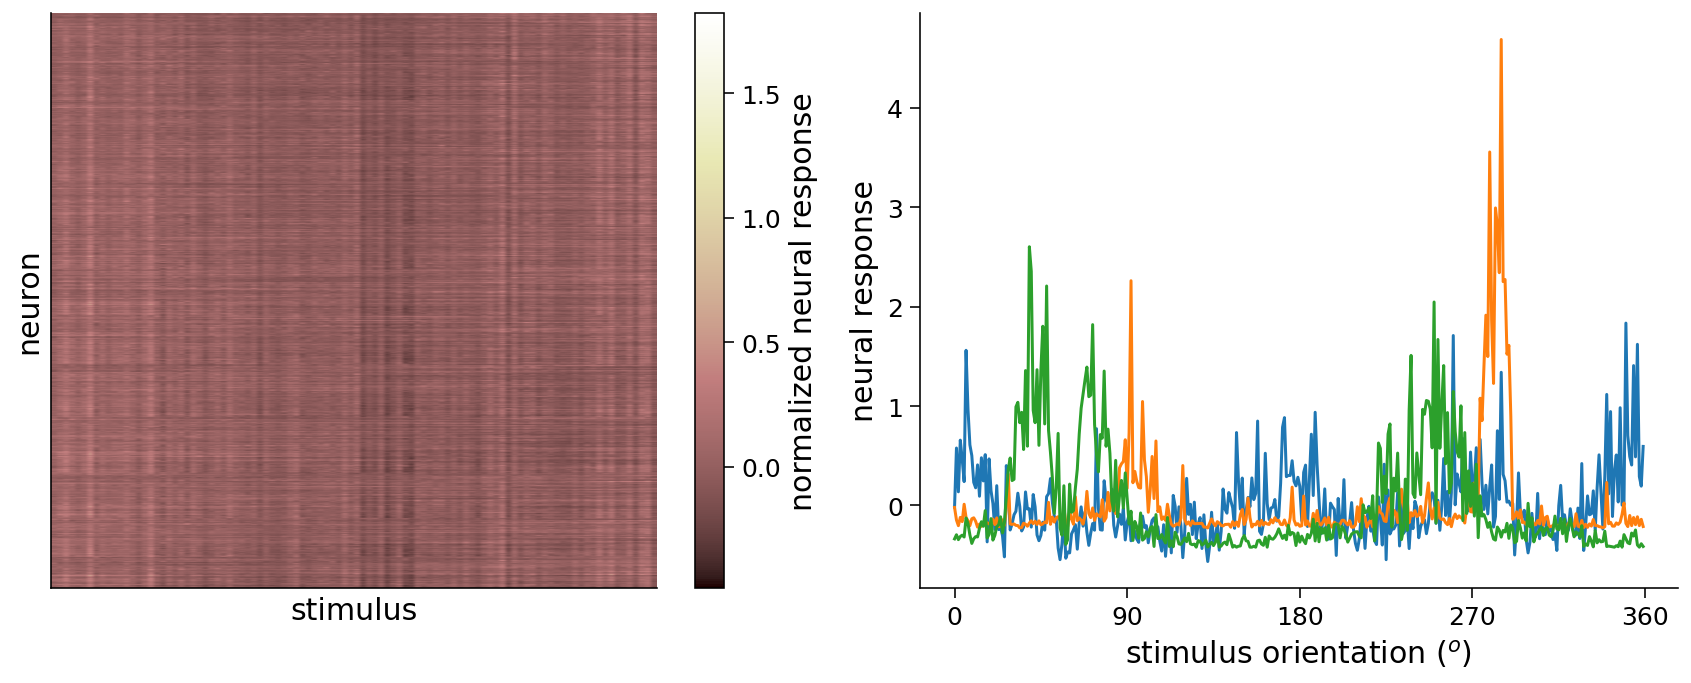

In [6]:
#@title

#@markdown Execute this cell to load and visualize data

# Load data
resp_all, stimuli_all = load_data()  # argument to this function specifies bin width
n_stimuli, n_neurons = resp_all.shape

print(f'{n_neurons} neurons in response to {n_stimuli} stimuli')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6, 5))

# Visualize data matrix
plot_data_matrix(resp_all[:100, :].T, ax1)  # plot responses of first 100 neurons
ax1.set_xlabel('stimulus')
ax1.set_ylabel('neuron')

# Plot tuning curves of three random neurons
ineurons = np.random.choice(n_neurons, 3, replace=False)  # pick three random neurons
ax2.plot(stimuli_all, resp_all[:, ineurons])
ax2.set_xlabel('stimulus orientation ($^o$)')
ax2.set_ylabel('neural response')
ax2.set_xticks(np.linspace(0, 360, 5))

plt.tight_layout()

We will split our data into a training set and test set. In particular, we will have a training set of orientations (`stimuli_train`)[ training data] and the corresponding responses (`resp_train`)[training labels]. Our testing set will have held-out orientations (`stimuli_test`)[test data] and the corresponding responses (`resp_test`)[test labels].

In [7]:
#@title
#@markdown Execute this cell to split into training and test sets

# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set
stimuli_test = stimuli_all[itest]
resp_test = resp_all[itest]
stimuli_train = stimuli_all[itrain]
resp_train = resp_all[itrain]

---
# Section 2: Deep feed-forward networks in *pytorch* 

We'll now build a simple deep neural network that takes as input a vector of neural responses and outputs a single number representing the decoded stimulus orientation.

To keep things simple, we'll build a deep network with **one** hidden layer.

Let $\mathbf{r}^{(n)} = \begin{bmatrix} r_1^{(n)} & r_2^{(n)} & \ldots & r_N^{(n)} \end{bmatrix}^T$ denote the vector of neural responses (of neurons $1, \ldots, N$) to the $n$th stimulus. The network we will use is described by the following set of equations:
\begin{align}
    \mathbf{h}^{(n)} &= \mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in}, && [\mathbf{W}^{in}: M \times N], \\
    y^{(n)} &= \mathbf{W}^{out} \mathbf{h}^{(n)} + \mathbf{b}^{out},  && [\mathbf{W}^{out}: 1 \times M],
\end{align}
where $y^{(n)}$ denotes the scalar output of the network: the decoded orientation of the $n$th stimulus.Dimension of $\mathbf{b}^{in}$ and $\mathbf{b}^{out}$ are same as $\mathbf{h}^{n}$ and $\mathbf{y}^{n}$ ($i.e.$$M\times1$ and $1\times N$) respectively which you can clearly see why.

The $M$-dimensional vector $\mathbf{h}^{(n)}$ denotes the activations of the **hidden layer** of the network. 

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/one-layer-network.png?raw=true" width="450" />
</p>

The blue components of this diagram denote the **parameters** of the network, which we will later optimize with gradient descent. These include all the weights and biases $\mathbf{W}^{in}, \mathbf{b}^{in}, \mathbf{W}^{out}, \mathbf{b}^{out}$.



### Section 2.1: Introduction to PyTorch

Here, we'll use the **PyTorch** package to build, run, and train deep networks of this form in Python. There are two core components to the PyTorch package: 

1. The first is the `torch.Tensor` data type used in PyTorch. `torch.Tensor`'s are effectively just like a `numpy` arrays, except that they have some important attributes and methods needed for automatic differentiation (to be discussed below). They also come along with infrastructure for easily storing and computing with them on GPU's, a capability we won't touch on here but which can be really useful in practice.

2. The second core ingredient is the PyTorch `nn.Module` class. This is the class we'll use for constructing deep networks, so that we can then easily train them using built-in PyTorch functions. Keep in my mind that `nn.Module` classes can actually be used to build, run, and train any model -- not just deep networks!

  The next cell contains code for building the deep network we defined above using the `nn.Module` class. It contains three key ingredients:

  * `__init__()` method to initialize its parameters, like in any other Python class. In this case, it takes two arguments:
    * `n_inputs`: the number of input units. This should always be set to the number of neurons whose activities are being decoded (i.e. the dimensionality of the input to the network). 
    * `n_hidden`: the number of hidden units. This is a parameter that we are free to vary in deciding how to build our network.

  * `nn.Linear` modules, which are built-in PyTorch classes containing all the weights and biases for a given network layer (documentation [here](https://pytorch.org/docs/master/generated/torch.nn.Linear.html)). This class takes two arguments to initialize:
    * \# of inputs to that layer
    * \# of outputs from that layer

    For the input layer, for example, we have:
    * \# of inputs = \# of neurons whose responses are to be decoded ($N$, specified by `n_inputs`)
    * \# of outputs = \# of hidden layer units ($M$, specified by `n_hidden`)
    
    PyTorch will initialize all weights and biases randomly.

  * `forward()` method, which takes as argument an input to the network and returns the network output. In our case, this comprises computing the output $y$ from a given input $\mathbf{r}$ using the above two equations. See the next cell for code implementing this computation using the built-in PyTorch `nn.Linear` classes.

In [8]:
class DeepNet(nn.Module):
  """Deep Network with one hidden layer

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    """Decode stimulus orientation from neural responses

    Args:
      r (torch.Tensor): vector of neural responses to decode, must be of
        length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
        containing n_stimuli vectors of neural responses

    Returns:
      torch.Tensor: network outputs for each input provided in r. If
        r is a vector, then y is a 1D tensor of length 1. If r is a 2D
        tensor then y is a 2D tensor of shape n_stimuli x 1.

    """
    h = self.in_layer(r)  # hidden representation
    y = self.out_layer(h)
    return y

The next cell contains code for initializing and running this network. We use it to decode stimulus orientation from a vector of neural responses to the very first stimulus. Note that when the initialized network class is called as a function on an input (e.g. `net(r)`), its `.forward()` method is called. This is a special property of the `nn.Module` class.

Note that the decoded orientations at this point will be nonsense, since the network has been initialized with random weights. Below, we'll learn how to optimize these weights for good stimulus decoding.

In [9]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=200 hidden units
net = DeepNet(n_neurons, 200)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)  # using helper function get_data

# Decode orientation from these neural responses using initialized network
out = net(r)  # compute output from network, equivalent to net.forward(r)

print('decoded orientation: %.2f degrees' % out)
print('true orientation: %.2f degrees' % ori)

decoded orientation: 0.08 degrees
true orientation: 139.00 degrees


---
### Section 2.2: Activation functions

Video available at https://youtu.be/JAdukDCQALA


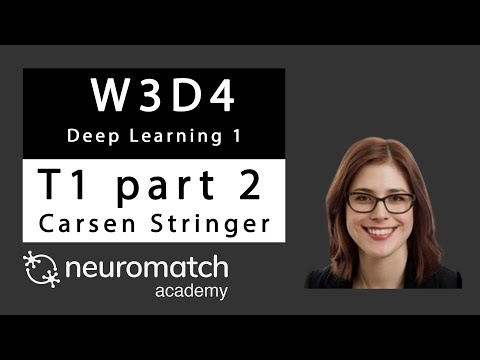

In [10]:
#@title Video 2: Nonlinear activation functions
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="JAdukDCQALA", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Note that the deep network we constructed above comprises solely **linear** operations on each layer: each layer is just a weighted sum of the elements in the previous layer. It turns out that linear hidden layers like this aren't particularly useful, since a sequence of linear transformations is actually essentially the same as a single linear transformation. We can see this from the above equations by plugging in the first one into the second one to obtain
\begin{equation}
    y^{(n)} = \mathbf{W}^{out} \left( \mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in} \right) + \mathbf{b}^{out} = \mathbf{W}^{out}\mathbf{W}^{in} \mathbf{r}^{(n)} + \left( \mathbf{W}^{out}\mathbf{b}^{in} + \mathbf{b}^{out} \right)
\end{equation}
In other words, the output is still just a weighted sum of elements in the input -- the hidden layer has done nothing to change this.

To extend the set of computable input/output transformations to more than just weighted sums, we'll incorporate a **non-linear activation function** in the hidden units. This is done by simply modifying the equation for the hidden layer activations to be
\begin{equation}
    \mathbf{h}^{(n)} = \phi(\mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in})
\end{equation}
where $\phi$ is referred to as the activation function. Using a non-linear activation function will ensure that the hidden layer performs a non-linear transformation of the input, which will make our network much more powerful (or *expressive*, cf. appendix). In practice, deep networks *always* use non-linear activation functions.



#### Exercise 1: Nonlinear Activations 

Create a new class `DeepNetReLU` by modifying our above deep network model to use a non-linear activation function. We'll use the linear rectification function:
\begin{equation}
  \phi(x) = 
  \begin{cases}
    x & \text{if } x > 0 \\
    0 & \text{else}
  \end{cases}
\end{equation}
which can be implemented in PyTorch using `torch.relu()`. Hidden layers with this activation function are typically referred to as "**Re**ctified **L**inear **U**nits", or **ReLU**'s.

Initialize this network with 20 hidden units and run on an example stimulus.

**Hint**: you only need to modify the `forward()` method of the above `DeepNet()` class.


In [55]:
class DeepNetReLU(nn.Module):

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):

    ############################################################################
    ## TO DO for students: write code for computing network output using a
    ## rectified linear activation function for the hidden units
    # Fill out function and remove
    #raise NotImplementedError("Student exercise: complete DeepNetReLU forward")
    ############################################################################

    h = torch.relu(self.in_layer(r))
    y = self.out_layer(h)

    return y


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)

# Uncomment to test your class

# Initialize deep network with M=20 hidden units and uncomment lines below
net = DeepNetReLU(n_neurons, 20)

# Decode orientation from these neural responses using initialized network
# net(r) is equivalent to net.forward(r)
out = net(r)


print('decoded orientation: %.2f degrees' % out)
print('true orientation: %.2f degrees' % ori)

decoded orientation: 0.13 degrees
true orientation: 139.00 degrees


You should see that the decoded orientation is 0.13 $^{\circ}$ while the true orientation is 139.00 $^{\circ}$.

---
# Section 3: Loss functions and gradient descent

Video available at https://youtu.be/aEtKpzEuviw


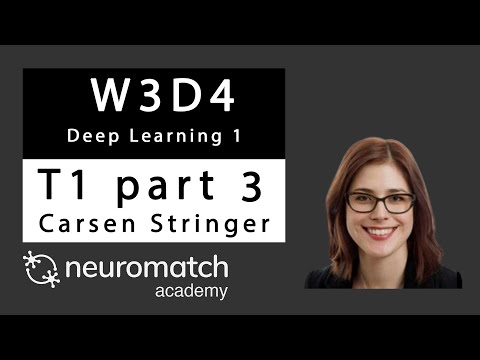

In [14]:
#@title Video 3: Loss functions & gradient descent
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="aEtKpzEuviw", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### Section 3.1: Loss functions

Because the weights of the network are currently randomly chosen, the outputs of the network are nonsense: the decoded stimulus orientation is nowhere close to the true stimulus orientation. We'll shortly write some code to change these weights so that the network does a better job of decoding.

But to do so, we first need to define what we mean by "better". One simple way of defining this is to use the squared error
\begin{equation}
    L = (y - \tilde{y})^2
\end{equation}
where $y$ is the network output and $\tilde{y}$ is the true stimulus orientation. When the decoded stimulus orientation is far from the true stimulus orientation, $L$ will be large. We thus refer to $L$ as the **loss function**, as it quantifies how *bad* the network is at decoding stimulus orientation.

PyTorch actually carries with it a number of built-in loss functions. The one corresponding to the squared error is called `nn.MSELoss()`. This will take as arguments a **batch** of network outputs $y_1, y_2, \ldots, y_P$ and corresponding target outputs $\tilde{y}_1, \tilde{y}_2, \ldots, \tilde{y}_P$, and compute the **mean squared error (MSE)**
\begin{equation}
    L = \frac{1}{P}\sum_{n=1}^P \left(y^{(n)} - \tilde{y}^{(n)}\right)^2
\end{equation}



In [56]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=20 hidden units
net = DeepNetReLU(n_neurons, 20)

# Get neural responses to first 20 stimuli in the data set
r, ori = get_data(20, resp_train, stimuli_train)

# Decode orientation from these neural responses
out = net(r)



###################################################
## TO DO for students: evaluate mean squared error
###################################################

# Initialize PyTorch mean squared error loss function (Hint: look at nn.MSELoss)
loss_fn = nn.MSELoss()

# Evaluate mean squared error
loss = loss_fn(ori,out)

# Uncomment once above is filled in
print('mean squared error: %.2f' % loss)

mean squared error: 42943.75


You should see a mean squared error of 42943.75.

---
### Section 3.2: Optimization with gradient descent

Our goal is now to modify the weights to make the mean squared error loss $L$ as small as possible over the whole data set. To do this, we'll use the **gradient descent (GD)** algorithm, which consists of iterating three steps:
1. **Evaluate the loss** on the training data,
```
out = net(train_data)
loss = loss_fn(out, train_labels)
```
where `train_data` are the network inputs in the training data (in our case, neural responses), and `train_labels` are the target outputs for each input (in our case, true stimulus orientations).
2. **Compute the gradient of the loss** with respect to each of the network weights. In PyTorch, we can do this with one line of code:
```
loss.backward()
```
This command tells PyTorch to compute the gradients of the quantity stored in the variable `loss` with respect to each network parameter using [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). These gradients are then stored behind the scenes 
3. **Update the network weights** by descending the gradient. In Pytorch, we can do this using built-in optimizers. We'll use the `optim.SGD` optimizer (documentation [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)) which updates parameters along the negative gradient, scaled by a learning rate (see appendix for details). To initialize this optimizer, we have to tell it
  * which parameters to update, and
  * what learning rate to use

  For example, to optimize *all* the parameters of a network `net` using a learning rate of .001, the optimizer would be initialized as follows
  ```
  optimizer = optim.SGD(net.parameters(), lr=.001)
  ```
  where `.parameters()` is a method of the `nn.Module` class that returns a [Python generator object](https://wiki.python.org/moin/Generators) over all the parameters of that `nn.Module` class (in our case, $\mathbf{W}^{in}, \mathbf{b}^{in}, \mathbf{W}^{out}, \mathbf{b}^{out}$).
  
  After computing all the parameter gradients in step 2, we can then update each of these parameters using the `.step()` method of this optimizer,
  ```
  optimizer.step()
  ```
  This single line of code will extract all the gradients computed with `.backward()` and execute the SGD updates for each parameter given to the optimizer. Note that this is true no matter how big/small the network is, allowing us to use the same two lines of code to perform the gradient descent updates for any deep network model built using PyTorch.

Finally, an important detail to remember is that the gradients of each parameter need to be cleared before calling `.backward()`, or else PyTorch will try to accumulate gradients across iterations. This can again be done using built-in optimizers via the method `zero_grad()`, as follows:
```
optimizer.zero_grad()
```

Putting all this together, each iteration of the GD algorith will contain a block of code that looks something like this:
```
Get outputs from network
Evaluate loss

# Compute gradients
optimizer.zero_grad()  # clear gradients
loss.backward()

# Update weights
optimizer.step()
```

In the next exercise, we'll give you a code skeleton for implementing the GD algorithm. Your job will be to fill in the blanks.


#### Exercise 3: Gradient descent in PyTorch

Complete the function `train()` that uses the gradient descent algorithm to optimize the weights of a given network. This function takes as input arguments
* `net`: the PyTorch network whose weights to optimize
* `loss_fn`: the PyTorch loss function to use to evaluate the loss
* `train_data`: the training data to evaluate the loss on (i.e. neural responses to decode)
* `train_labels`: the target outputs for each data point in `train_data` (i.e. true stimulus orientations)

We will then train a neural network on our data and plot the loss (mean squared error) over time. When we run this function, behind the scenes PyTorch is actually changing the parameters inside this network to make the network better at decoding, so its weights will now be different than they were at initialization.


**Hint:** all the code you need for doing this is provided in the above description of the GD algorithm.

iteration 10/50 | loss: 11225.866
iteration 20/50 | loss: 796.538
iteration 30/50 | loss: 449.642
iteration 40/50 | loss: 285.460
iteration 50/50 | loss: 186.747


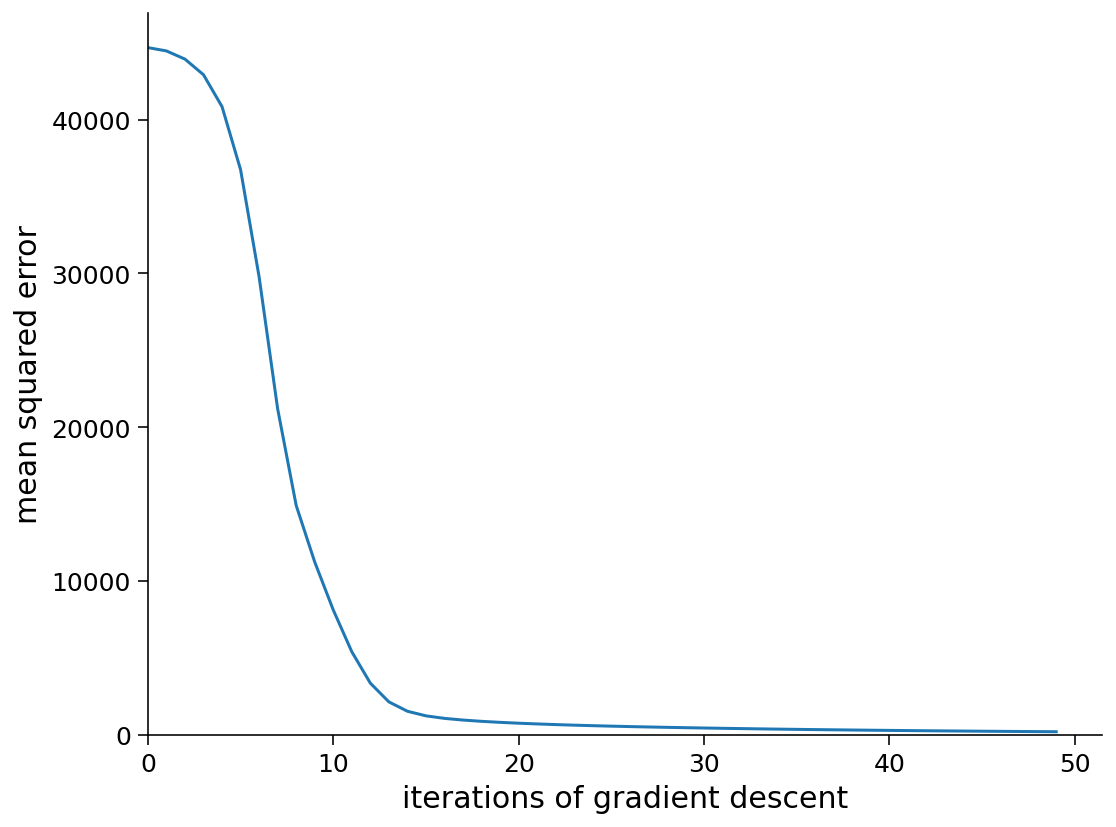

In [57]:
def train(net, loss_fn, train_data, train_labels, n_iter=50, learning_rate=1e-4):
  """Run gradient descent to opimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    n_iter (int): number of iterations of gradient descent to run
    learning_rate (float): learning rate to use for gradient descent

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  track_loss = []

  # Loop over epochs (cf. appendix)
  for i in range(n_iter):

    ######################################################################
    ## TO DO for students: fill in missing code for GD iteration
    #raise NotImplementedError("Student exercise: write code for GD iterations")
    ######################################################################

    # Evaluate loss using loss_fn
    out = net(train_data)  # compute network output from inputs in train_data
    loss = loss_fn(out,train_labels)  # evaluate loss function

    # Compute gradients
    optimizer.zero_grad()
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    track_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_iter // 5) == 0:
      print(f'iteration {i + 1}/{n_iter} | loss: {loss.item():.3f}')

  return track_loss

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network
net = DeepNetReLU(n_neurons, 20)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Run GD on data
train_loss = train(net, loss_fn, resp_train, stimuli_train)

# Plot the training loss over iterations of GD
plt.plot(train_loss)
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('iterations of gradient descent')
plt.ylabel('mean squared error')
plt.show()

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D4_DeepLearning1/static/W3D4_Tutorial1_Solution_8f827dbe_1.png>


---
# Section 4: Evaluating model performance

## Section 4.1: Generalization performance with test data

Note that gradient descent is essentially an algorithm for fitting the network's parameters to a given set of training data. Selecting this training data is thus crucial for ensuring that the optimized parameters **generalize** to unseen data they weren't trained on. In our case, for example, we want to make sure that our trained network is good at decoding stimulus orientations from neural responses to any orientation, not just those in our data set.

To ensure this, we have split up the full data set into a **training set** and a **testing set**. In Exercise 3, we trained a deep network by optimizing the parameters on a training set. We will now evaluate how good the optimized parameters are by using the trained network to decode stimulus orientations from neural responses in the testing set. Good decoding performance on this testing set should then be indicative of good decoding performance on the neurons' responses to any other stimulus orientation. This procedure is commonly used in machine learning (not just in deep learning)and is typically referred to as **cross-validation**.

We will compute the MSE on the test data and plot the decoded stimulus orientations as a function of the true stimulus.

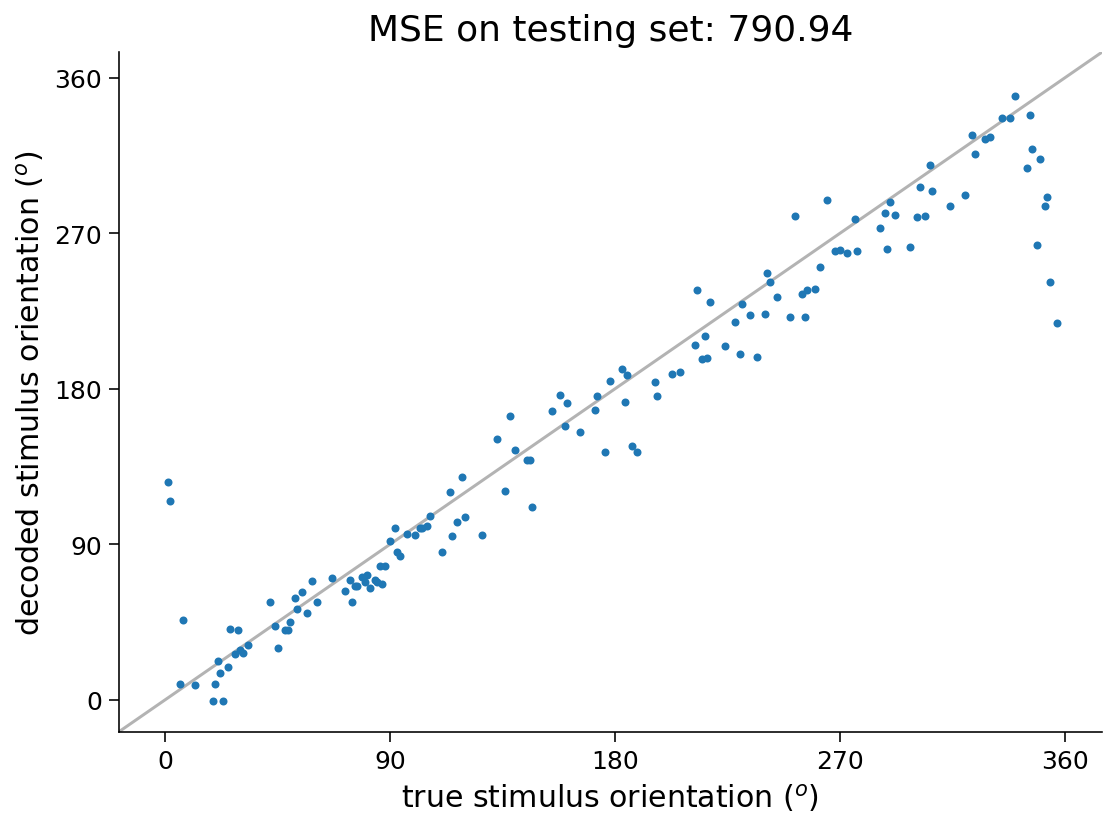

In [58]:
#@title
#@markdown Execute this cell to evaluate and plot test error

out = net(resp_test)  # decode stimulus orientation for neural responses in testing set
ori = stimuli_test  # true stimulus orientations
test_loss = loss_fn(out, ori)  # MSE on testing set (Hint: use loss_fn initialized in previous exercise)

plt.plot(ori, out.detach(), '.')  # N.B. need to use .detach() to pass network output into plt.plot()
identityLine()  # draw the identity line y=x; deviations from this indicate bad decoding!
plt.title('MSE on testing set: %.2f' % test_loss.item())  # N.B. need to use .item() to turn test_loss into a scalar
plt.xlabel('true stimulus orientation ($^o$)')
plt.ylabel('decoded stimulus orientation ($^o$)')
axticks = np.linspace(0, 360, 5)
plt.xticks(axticks)
plt.yticks(axticks)
plt.show()


In the cell below, we will plot the *decoding error* for each neural response in the testing set. The decoding error is defined as the decoded stimulus orientation minus true stimulus orientation
\begin{equation}
  \text{decoding error} = y^{(n)} - \tilde{y}^{(n)}
\end{equation}

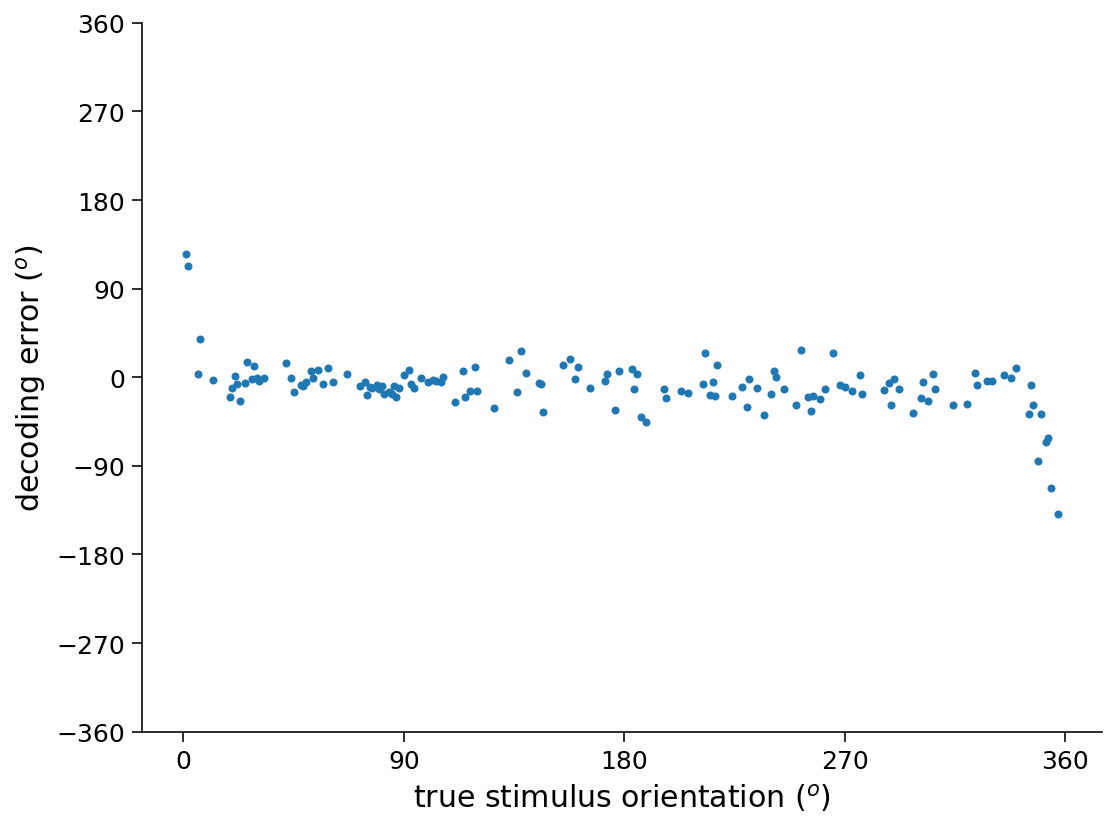

In [59]:
#@title
#@markdown Execute this cell to plot decoding error

out = net(resp_test)  # decode stimulus orientation for neural responses in testing set
ori = stimuli_test  # true stimulus orientations
error = out - ori  # decoding error


plt.plot(ori, error.detach(), '.')   # plot decoding error as a function of true orientation (make sure all arguments to plt.plot() have been detached from PyTorch network!)

# Plotting
plt.xlabel('true stimulus orientation ($^o$)')
plt.ylabel('decoding error ($^o$)')
plt.xticks(np.linspace(0, 360, 5))
plt.yticks(np.linspace(-360, 360, 9))
plt.show()

It appears that the errors are larger at 0 and 360 degrees. The errors are biased
in the positive direction at 0 degrees and in the negative direction at 360 degrees.
This is because the 0 degree stimulus and the 360 degree stimulus are in fact the
same because orientation is a circular variable. The network therefore has trouble
determining whether the stimulus is 0 or 360 degrees.
We can modify the deep network to avoid this problem in a few different ways.

One thing that could be done is to bin the stimulus responses and predict the bin of the stimulus.
This turns the problem into a classification problem rather than a regression problem,
and in this case you will need to use a new loss function (see below).

### Exercise 4: Improving the loss function 
As illustrated in the previous exercise, the squared error is not a good loss function for circular quantities like angles, since two angles that are very close (e.g. $1^o$ and $359^o$) might actually have a very large squared error.

Here, we'll avoid this problem by changing our loss function to treat our decoding problem as a **classification problem**. Rather than estimating the *exact* angle of the stimulus, we'll now aim to construct a decoder that classifies the stimulus into one of $C$ classes, corresponding to different bins of angles of width $b = \frac{360}{C}$. The true class $\tilde{y}^{(n)}$ of stimulus $i$ is now given by
\begin{equation}
  \tilde{y}^{(n)} =
  \begin{cases}
    1 &\text{if angle of stimulus $n$ is in the range } [0, b] \\
    2 &\text{if angle of stimulus $n$ is in the range } [b, 2b] \\
    3 &\text{if angle of stimulus $n$ is in the range } [2b, 3b] \\
    \vdots \\
    C &\text{if angle of stimulus $n$ is in the range } [(C-1)b, 360]
  \end{cases}
\end{equation}

We have a helper function `stimulus_class` that will extract `n_classes` stimulus classes for us from the stimulus orientations.

To decode the stimulus class from neural responses, we'll use a deep network that outputs a $C$-dimensional vector of probabilities $\mathbf{p} = \begin{bmatrix} p_1, p_2, \ldots, p_C \end{bmatrix}^T$, corresponding to the estimated probabilities of the stimulus belonging to each class $1, 2, \ldots, C$. 

To ensure the network's outputs are indeed probabilities (i.e. they are positive numbers between 0 and 1, and sum to 1), we'll use a [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to transform the real-valued outputs from the hidden layer into probabilities. Letting $\sigma(\cdot)$ denote this softmax function, the equations describing our network are
\begin{align}
    \mathbf{h}^{(n)} &= \phi(\mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in}), && [\mathbf{W}^{in}: M \times N], \\
    \mathbf{p}^{(n)} &= \sigma(\mathbf{W}^{out} \mathbf{h}^{(n)} + \mathbf{b}^{out}),  && [\mathbf{W}^{out}: C \times M],
\end{align}
The decoded stimulus class is then given by that assigned the highest probability by the network:
\begin{equation}
  y^{(n)} = \underset{i}{\arg\max} \,\, p_i
\end{equation}
The softmax function can be implemented in PyTorch simply using `torch.softmax()`.

Often *log* probabilities are easier to work with than actual probabilities, because probabilities tend to be very small numbers that computers have trouble representing. We'll therefore actually use the logarithm of the softmax as the output of our network,
\begin{equation}
    \mathbf{l}^{(n)} = \log \left( \mathbf{p}^{(n)} \right)
\end{equation}
which can implemented in PyTorch together with the softmax via an `nn.LogSoftmax` layer. The nice thing about the logarithmic function is that it's *monotonic*, so if one probability is larger/smaller than another, then its logarithm is also larger/smaller than the other's. We therefore have that
\begin{equation}
  y^{(n)} = \underset{i}{\arg\max} \,\, p_i^{(n)} = \underset{i}{\arg\max} \, \log p_i^{(n)} = \underset{i}{\arg\max} \,\, l_i^{(n)}
\end{equation}

See the next cell for code for constructing a deep network with one hidden layer that of ReLU's that outputs a vector of log probabilities.

In [71]:
# Deep network for classification
class DeepNetSoftmax(nn.Module):
  """Deep Network with one hidden layer, for classification

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer
    n_classes (int): number of outputs, i.e. number of classes to output
      probabilities for

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden, n_classes):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden)  # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, n_classes)  # hidden units --> outputs
    self.logprob = nn.LogSoftmax(dim=1)  # probabilities across columns should sum to 1 (each output row corresponds to a different input)

  def forward(self, r):
    """Predict stimulus orientation bin from neural responses

    Args:
      r (torch.Tensor): n_stimuli x n_inputs tensor with neural responses to n_stimuli

    Returns:
      torch.Tensor: n_stimuli x n_classes tensor with predicted class probabilities

    """
    h = torch.relu(self.in_layer(r))
    logp = self.logprob(self.out_layer(h))
    return logp

What should our loss function now be? Ideally, we want the probabilities outputted by our network to be such that the probability of the true stimulus class is high. One way to formalize this is to say that we want to maximize the *log* probability of the true stimulus class $\tilde{y}^{(n)}$ under the class probabilities predicted by the network,
\begin{equation}
  \log \left( \text{predicted probability of stimulus } n \text{ being of class } \tilde{y}^{(n)} \right) = \log p^{(n)}_{\tilde{y}^{(n)}} = l^{(n)}_{\tilde{y}^{(n)}}
\end{equation}
To turn this into a loss function to be *minimized*, we can then simply multiply it by -1: maximizing the log probability is the same as minimizing the *negative* log probability. Summing over a batch of $P$ inputs, our loss function is then given by
\begin{equation}
  L = -\sum_{n=1}^P \log p^{(n)}_{\tilde{y}^{(n)}} = -\sum_{n=1}^P l^{(n)}_{\tilde{y}^{(n)}}
\end{equation}
In the deep learning community, this loss function is typically referred to as the **cross-entropy**, or **negative log likelihood**. The corresponding built-in loss function in PyTorch is `nn.NLLLoss()` (documentation [here](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html)).

In the next cell, we've provided most of the code to train and test a network to decode stimulus orientations via classification, by minimizing the negative log likelihood. Fill in the missing pieces.

Once you've done this, have a look at the plotted results. Does changing the loss function from mean squared error to a classification loss solve our problems? Note that errors may still occur -- but are these errors as bad as the ones that our network above was making?

iteration 10/50 | loss: 0.543
iteration 20/50 | loss: 0.179
iteration 30/50 | loss: 0.095
iteration 40/50 | loss: 0.061
iteration 50/50 | loss: 0.044


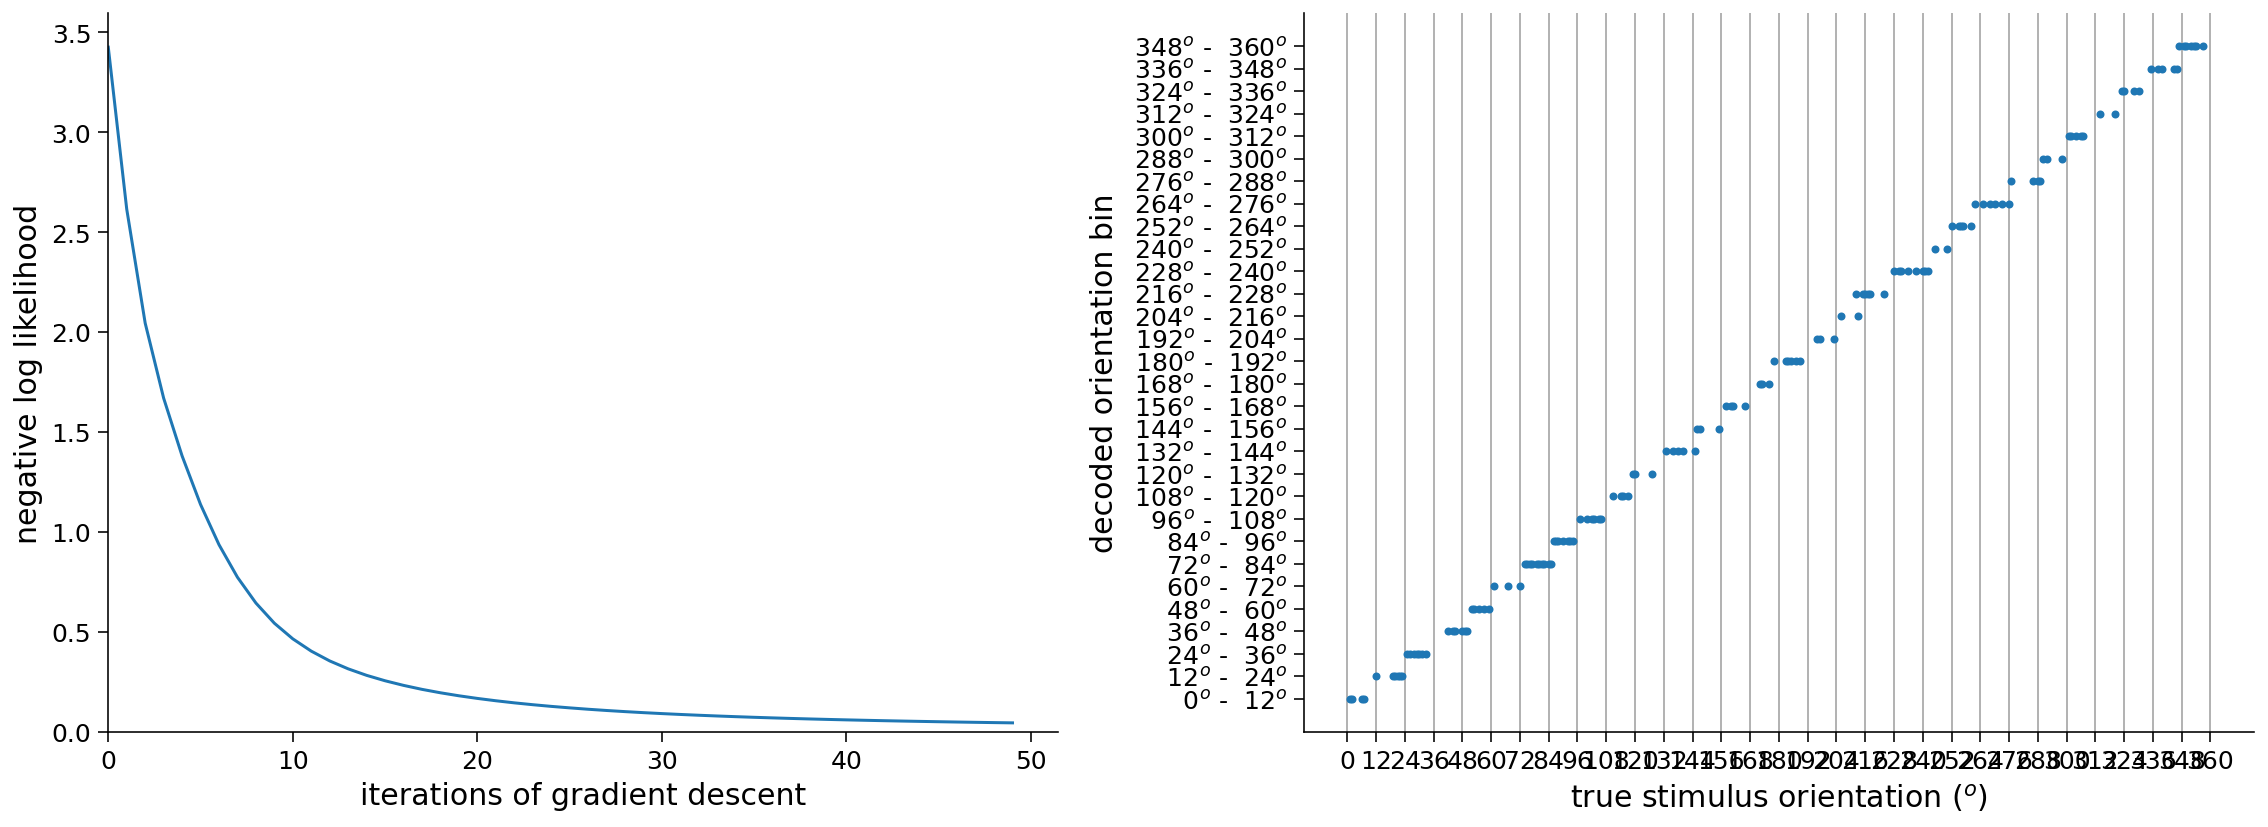

In [80]:
def decode_orientation(n_classes, train_data, train_labels, test_data, test_labels):
  """ Initialize, train, and test deep network to decode binned orientation from neural responses

  Args:
    n_classes (scalar): number of classes in which to bin orientation
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    test_data (torch.Tensor): n_test x n_neurons tensor with neural
      responses to train on
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (list, torch.Tensor): training loss over iterations, n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network
  """

  # Bin stimulus orientations in training set
  train_binned_labels = stimulus_class(train_labels, n_classes)

  ##############################################################################
  ## TODO for students: fill out missing pieces below to initialize, train, and
  # test network
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: complete decode_orientation function")
  ##############################################################################

  # Initialize network
  net = DeepNetSoftmax(n_neurons,20,n_classes)  # use M=20 hidden units

  # Initialize built-in PyTorch MSE loss function
  loss_fn = nn.NLLLoss()

  # Run GD on training set data, using learning rate of 0.1
  
  train_loss = train(net, loss_fn, train_data, train_binned_labels,50,0.1)

  # Decode neural responses in testing set data
  out = net(test_data)
  out_labels = np.argmax(out.detach(), axis=1)  # predicted classes

  return train_loss, out_labels


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

n_classes = 30  # start with 12, then (bonus) try making this as big as possible! does decoding get worse?

# Uncomment below to test your function

# Initialize, train, and test network
train_loss, predicted_test_labels = decode_orientation(n_classes, resp_train, stimuli_train, resp_test, stimuli_test)

# Plot results
plot_decoded_results(train_loss, stimuli_test, predicted_test_labels)

---
# Summary

We have now covered a number of common and powerful techniques for applying deep learning to decoding from neural data, some of which are common to almost any machine learning problem:
* Building and training deep networks using the **PyTorch** `nn.Module` class and built-in **optimizers**
* Choosing and evaluating **loss functions**
* Testing a trained model on unseen data via **cross-validation**, by splitting the data into a **training set and testing set**

If you are interested then you can now learn how the gradients of our loss function are calculated with respect to parameters of our model and you can also see documentation of various classes and methods used in this tutorial.

All credits to Neuromatch Academy for this amazing notebook.

We hope this tutorial was fascinating and you learnt at lot from it!